In [1]:
import numpy as np
import pandas as pd
import requests
from epiweeks import Week, Year
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
location_codes = {'Deutschland': 'DE',
                  'Schleswig-Holstein': 'DE-SH',
                  'Hamburg': 'DE-HH',
                  'Niedersachsen': 'DE-NI',
                  'Bremen': 'DE-HB',
                  'Nordrhein-Westfalen': 'DE-NW',
                  'Hessen': 'DE-HE',
                  'Rheinland-Pfalz': 'DE-RP',
                  'Baden-Württemberg': 'DE-BW',
                  'Bayern': 'DE-BY',
                  'Saarland': 'DE-SL',
                  'Berlin': 'DE-BE',
                  'Brandenburg': 'DE-BB',
                  'Mecklenburg-Vorpommern': 'DE-MV',
                  'Sachsen': 'DE-SN',
                  'Sachsen-Anhalt': 'DE-ST',
                  'Thüringen': 'DE-TH'}

In [3]:
PATH = 'https://raw.githubusercontent.com/KITmetricslab/nowcasting-data/main/'
DISEASE = 'Seasonal_Influenza' #'RSV_Infection''Pneumococcal_Disease'    
TYPE = 'states'

In [4]:
MAX_DELAY = 10

In [5]:
url = 'https://api.github.com/repos/KITmetricslab/nowcasting-data/git/trees/main?recursive=1'
r = requests.get(url)
res = r.json()

files = sorted([file['path'] for file in res['tree'] if (file['path'].startswith(DISEASE) and 
                                                         file['path'].endswith('.csv') and
                                                         TYPE in file['path'])])

In [6]:
df_files = pd.DataFrame({'filename':files})

# extract date from filename
df_files['date'] = df_files.filename.str[-14:-4]
df_files.date = pd.to_datetime(df_files.date)

In [7]:
df_files.head()

,filename,date
0,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-10-27
1,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-10-28
2,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-01
3,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-02
4,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-03


In [8]:
def add_iso_dates(df):
    '''
    Adds iso_week, iso_year and iso_date (end date of the week) to dataframe.
    '''
    df['iso_week'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').week)
    df['iso_year'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').year)
    df['iso_date'] = df_files.apply(lambda x: Week(x.iso_year, x.iso_week, system = 'iso').enddate(), axis = 1)
    
    return(df)

In [9]:
df_files = add_iso_dates(df_files)

In [10]:
df_files.head()

,filename,date,iso_week,iso_year,iso_date
0,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-10-27,43,2021,2021-10-31
1,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-10-28,43,2021,2021-10-31
2,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-01,44,2021,2021-11-07
3,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-02,44,2021,2021-11-07
4,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-03,44,2021,2021-11-07


In [11]:
# only keep latest file per week
df_files = df_files.sort_values('date').groupby(['iso_year', 'iso_week']).tail(1).reset_index(drop = True)

In [12]:
df_files.head()

,filename,date,iso_week,iso_year,iso_date
0,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-10-28,43,2021,2021-10-31
1,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-07,44,2021,2021-11-07
2,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-14,45,2021,2021-11-14
3,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-21,46,2021,2021-11-21
4,Seasonal_Influenza/Seasonal_Influenza-states-2...,2021-11-28,47,2021,2021-11-28


In [13]:
dfs = []
for i, row in df_files.iterrows():
    try:
        df_temp = pd.read_csv(PATH + row['filename'])
        df_temp = df_temp[(df_temp.week == row['iso_week']) & (df_temp.year == row['iso_year'])]
        dfs.append(df_temp)
    except:
        print(f"Warning: {row['filename']} could not be loaded and was skipped.")

df = pd.concat(dfs)

# df.stratum.replace({'Ã.': 'ü', '\.': '-'}, regex = True, inplace = True)

df['date'] = df.apply(lambda x: Week(x.year, x.week, system = 'iso').enddate(), axis = 1)

# if initial report is missing replace with zero
df.value.fillna(0, inplace = True)

df = df[['stratum', 'year', 'week', 'date', 'value']]

df.rename(columns = {'value': 'value_0w'}, inplace = True)

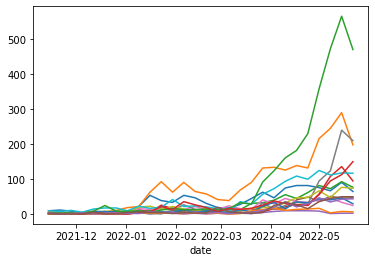

In [14]:
df.set_index('date').groupby('stratum')['value_0w'].plot();

In [15]:
dates = pd.Series(df.date.unique())

In [16]:
for delay in tqdm(range(1, MAX_DELAY + 1), total = MAX_DELAY):
    dfs_delayed = []
    for date in dates:
        date_delayed = date + pd.Timedelta(weeks = delay)
        if date_delayed <= max(dates):
            filename = df_files.loc[df_files.iso_date == date_delayed, 'filename'].values[0]
            df_temp = pd.read_csv(PATH + filename)
            # df_temp.stratum.replace({'Ã.': 'ü', '\.': '-'}, regex = True, inplace = True)
            df_temp['date'] = df_temp.apply(lambda x: Week(x.year, x.week, system = 'iso').enddate(), axis = 1)
            df_temp = df_temp[df_temp.date == date]
            dfs_delayed.append(df_temp)
    df_delayed = pd.concat(dfs_delayed)
    # we flag missing values to fill later on (not all should be filled to preserve reporting triangle shape)
    df_delayed.value.fillna('to_fill', inplace = True)  
    df_delayed.rename(columns = {'value': f'value_{delay}w'}, inplace = True)
    df = df.merge(df_delayed, how = 'left')

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# use latest file to compute column for remaining correction beyond the specified largest delay
df_latest = pd.read_csv(PATH + files[-1])

# df_latest.stratum.replace({'Ã.': 'ü', '\.': '-'}, regex = True, inplace = True)
df_latest['date'] = df_latest.apply(lambda x: Week(x.year, x.week, system = 'iso').enddate(), axis = 1)
df_latest.value = df_latest.value.fillna('to_fill')

df_latest = df_latest.rename(columns = {'value': f'value_>{MAX_DELAY}w'})

In [18]:
df = df.merge(df_latest, how = 'left')

In [19]:
df.head()

,stratum,year,week,date,value_0w,value_1w,value_2w,value_3w,value_4w,value_5w,value_6w,value_7w,value_8w,value_9w,value_10w,value_>10w
0,Baden.WÃ.rttemberg,2021,45,2021-11-14,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
1,Bayern,2021,45,2021-11-14,6.0,7.0,7.0,7.0,7.0,7.0,8.0,8.0,8.0,8.0,8.0,8.0
2,Berlin,2021,45,2021-11-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Brandenburg,2021,45,2021-11-14,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Bremen,2021,45,2021-11-14,0.0,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill,to_fill


In [20]:
# we want to keep the triangle shape and avoid filling the corresponding entries
df = df.fillna('not_observed')

# we use forward filling to fill missing values in between
df = df.replace({'to_fill' : np.nan})
df = df.fillna(method = "ffill", axis = 1)

df = df.replace({'not_observed' : np.nan})

In [21]:
# compute differences
df.iloc[:, 5:] = df.iloc[:, 4:].diff(axis=1).iloc[:, 1:]

In [22]:
value_cols = [c for c in df.columns if 'value' in c]
for col in value_cols:
    df[col] = df[col].astype('Int64')

df.stratum = df.stratum.replace({'Ã.': 'ü', '\.': '-'}, regex = True)

df['location'] = df.stratum.replace(location_codes)

df['age_group'] = '00+'

df = df[['location', 'age_group', 'year', 'week', 'date'] + value_cols]

df = df.sort_values(['location', 'age_group', 'date'])

In [23]:
df.to_csv(f'../data/truth/truth_{DISEASE.lower()}.csv', index = False)